# Notebook 5 : Approche supervisée avec BERT, USE et Word2vec

## 1. Libraries & Settings

In [1]:
#pip install torch gensim seaborn tensorflow_hub

In [13]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from bs4 import BeautifulSoup
from gensim.models import Word2Vec
import torch
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from transformers import BertTokenizer, BertModel
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.exceptions import ConvergenceWarning

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

warnings.filterwarnings("ignore", category=UserWarning, message=".*token_pattern.*")
warnings.filterwarnings("ignore", message="The parameter 'token_pattern' will not be used since 'tokenizer' is not None")
warnings.filterwarnings("ignore", category=UserWarning, message=".*looks more like a filename.*")
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.feature_extraction.text')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
pd.set_option('display.max_colwidth', None)

# Style pour les graphiques Seaborn
sns.set_style("darkgrid")
sns.set_palette("vlag")
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2})
sns.set(rc={
    'axes.labelsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'axes.labelcolor': 'gray',
    'xtick.color': 'gray',
    'ytick.color': 'gray',
    'axes.titlesize': 12,
})

## 2. Load Data

In [3]:
# Load Data
df = pd.read_csv("QueryResults.csv")

# Drop unnecessary columns
df.drop(columns=['Id', 'Score', 'ViewCount', 'AnswerCount', 'FavoriteCount'], inplace=True) #, 'FavoriteCount'
df = df.sample(frac=0.1, random_state=42)
df.reset_index(drop=True, inplace=True)

## 3. Preprocessing

In [4]:
# Function for cleaning TAGS ---------------------------------------------------------------------
special_words = {'c#', 'c++', 'f#', 'asp.net', 'vb.net', 'node.js', 'objective-c', 'ai'}

# Function for the 'Tags' colum ---------------------------------------------------------------------
def preprocess_tags(tags):
    def clean_word(word):        
        if word in special_words: # Preserve special words exactly
            return word        
        cleaned_word = re.sub(r"[^\w\s\-]", "", word) # Remove unwanted characters except hyphen, apostrophe        
        cleaned_word = re.sub(r"[-\d]+$", "", cleaned_word) # Remove trailing hyphens or numbers
        if re.search(r"\d", cleaned_word):  # Remove words containing any number
            return ""
        return cleaned_word    
        
    words = re.findall(r'(?<=<)(.*?)(?=>)', tags)  # Extract words
    processed_words = [
        clean_word(word) for word in words] # Keep words within length constraints 
    words = [subword for word in processed_words for subword in word.split()]  
    words = [w for w in words if len(w) > 2 or w in special_words] 
    return words

# Function for cleaning BODY & TITLE ---------------------------------------------------------------------
def clean_text(sentence):
    def clean_word(word):
        if word in special_words: # Preserve special words exactly
            return [word]
        cleaned_word = re.sub(r"(\'s|\'ve|\'d|\'ll|\'re|\'m|\'t)$", "", word) # Remove common contraction suffixes
        cleaned_word = re.sub(r"[^\w\s\-]", " ", cleaned_word) # Replace non-alphanumeric characters (except hyphens) with spaces
        cleaned_word = re.sub(r"^-+", "", cleaned_word) # Remove leading hyphens
        cleaned_word = re.sub(r"[-\d]+$", "", cleaned_word) # Remove trailing hyphens or numbers
        cleaned_word = cleaned_word.strip() # Trim whitespace
        
        if len(cleaned_word) < 3 and cleaned_word not in special_words: # Remove words with length < 3 unless in special_words
            return None
        
        split_words = re.split(r'[.\-#]', cleaned_word) # Split words like 'this.opacity' into 'this' and 'opacity'
        split_words = [sub_word for word in split_words for sub_word in word.split() if sub_word] # Additional split on spaces and remove empty strings
        return [w for w in split_words if w]
        
    soup = BeautifulSoup(sentence, "html.parser") # Remove HTML tags and convert to lowercase
    sentence = soup.get_text()
    sentence = sentence.lower()
    words = re.findall(r"\w+[-.#']?\w*|\S+", sentence)
    processed_words = [clean_word(word) for word in words]
    filtered_words = [
        word for sublist in processed_words if sublist for word in sublist
        if (word in special_words or len(word) > 2) 
        and '_' not in word  # Exclude words with underscores
        and word.isascii()  # Exclude non-ASCII words
        and not any(char.isdigit() for char in word)]  # Exclude words with digits
    return filtered_words
    
# STOP WORDS -------------------------------------------------------------------
stop_w = set(stopwords.words('english'))
def stop_word_filter(list_words):
    return [ w for w in list_words if w not in stop_w]

# LEMMA -------------------------------------------------------------------
lemmatizer = WordNetLemmatizer()
def lemma_words(list_words):
    return [lemmatizer.lemmatize(w, pos='v') for w in list_words]

# Remove specific words -------------------------------------------------------------------
words_to_exclude = {'however', 'good', 'use', 'anyone', 'say', 'problem','better', 'another', 'please', 'etc', 'actually','someone', 'happen', 'ask',  'maybe', 'look', 'little', 'advance',
'need', 'something', 'question', 'example', 'thank', 'also', 'cannot', 'think', 'anything', 'idea', 'thing', 'ideas', 'people', 'basically', 'nice', 'easily', 'feel',
'obviously', 'specifically', 'problem'}
def remove_words(tokens):
    tagged_tokens = nltk.pos_tag(tokens)
    tags_to_remove = {'MD', 'CD' } # 'WRB', 'WP$', 'PRP$', 'PDT', 'JJR',  'EX'
    return [ word for word, tag in tagged_tokens
        if tag not in tags_to_remove and word.lower() not in words_to_exclude]

# Preprocessing BODY & TITLE ---------------------------------------------------------------------
def custom_tokenizer(desc_text):
    cleaned = clean_text(desc_text)
    filtered = stop_word_filter(cleaned)
    lemmatized = lemma_words(filtered)
    words_removed = remove_words(lemmatized)
    return words_removed
    
# Apply preprocessing
df['Tags'] = df['Tags'].apply(preprocess_tags)
df['title_clean_bow'] = df['Title'].apply(custom_tokenizer)
df['body_clean_bow'] = df['Body'].apply(custom_tokenizer)

# Combine "Title" and "Body" 
df['combined_text_bow'] = df['title_clean_bow'] + df['body_clean_bow']
df['combined_text_bow'] = df['combined_text_bow'].apply(lambda x: ' '.join(x))
X = df['combined_text_bow']
y = df['Tags']

# MultiLabelBinarizer for target column
mlb = MultiLabelBinarizer()
y = pd.DataFrame(mlb.fit_transform(df['Tags']), columns=mlb.classes_)
top_tags = y.sum().sort_values(ascending=False).head(100).index
y_top_tags = y[top_tags]
y_top_tags = y_top_tags[y_top_tags.sum(axis=1) > 0]
X_filtered = X.loc[y_top_tags.index]  
y = y_top_tags
y.reset_index(drop=True, inplace=True)
X_filtered.reset_index(drop=True, inplace=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=42)

## 4. Word2Vec

In [5]:
# Tokeniser chaque texte en une list de mots
X_train_tokenized = [text.split() for text in X_train]
X_test_tokenized = [text.split() for text in X_test]

# Entraîner Word2Vec
word2vec_model = Word2Vec(sentences=X_train_tokenized, vector_size=100, window=5, min_count=20)

# Obtenir la représentation des documents en moyenne des vecteurs des mots
def vectorize_with_word2vec(model, documents):
    document_vectors = []
    for doc in documents:
        word_vectors = [model.wv[word] for word in doc if word in model.wv]
        if word_vectors:  # Si le document contient des mots du modèle
            document_vectors.append(np.mean(word_vectors, axis=0))
        else:  # Si aucun mot du document n'est dans le modèle
            document_vectors.append(np.zeros(model.vector_size))
    return np.array(document_vectors)

# Vectorisation des données d'entraînement et de test
X_train_w2v = vectorize_with_word2vec(word2vec_model, X_train_tokenized)
X_test_w2v = vectorize_with_word2vec(word2vec_model, X_test_tokenized)

print('Vocabulary size:', len(word2vec_model.wv))
print("Shape of X_train_w2v:", X_train_w2v.shape)
print("Shape of X_test_w2v:", X_test_w2v.shape)

# word2vec_model.wv.index_to_key
# word2vec_model.corpus_count
# word2vec_model.epochs
word2vec_model.wv.similar_by_word('google')
# word2vec_model.wv['google'].shape
# word2vec_model.wv['google']

# X_train_tokenized[1]
# X_train_w2v[1]

Vocabulary size: 2064
Shape of X_train_w2v: (3728, 100)
Shape of X_test_w2v: (933, 100)


[('site', 0.9237365126609802),
 ('api', 0.8676837682723999),
 ('wordpress', 0.8487489223480225),
 ('blog', 0.8482675552368164),
 ('documentation', 0.8481871485710144),
 ('facebook', 0.842408299446106),
 ('engine', 0.8412674069404602),
 ('demo', 0.8362634181976318),
 ('plugin', 0.8269495964050293),
 ('stackoverflow', 0.825577974319458)]

This plot visualizes the word embeddings created using Word2Vec, clustered into ten distinct groups using the KMeans clustering algorithm and projected into two dimensions using PCA. 
1. **Dimensionality Reduction**
   - Word embeddings, originally in high-dimensional space (100 dimensions in my code), are reduced to two dimensions using PCA for visualization.
   - Each point in the plot represents a word in the vocabulary.

2. **Clusters**
   - KMeans was used to group similar words into **10 clusters**, based on their proximity in the embedding space.
   - Words in the same cluster (having the same label) are expected to be semantically or contextually related.  

3. **Interpretation of Clusters**
   - The dense region in the center contains words that are more generic or commonly shared across contexts, making their embeddings more similar.
   - Outliers or words further from the center are likely more domain-specific or less frequently used, giving them distinct embeddings.

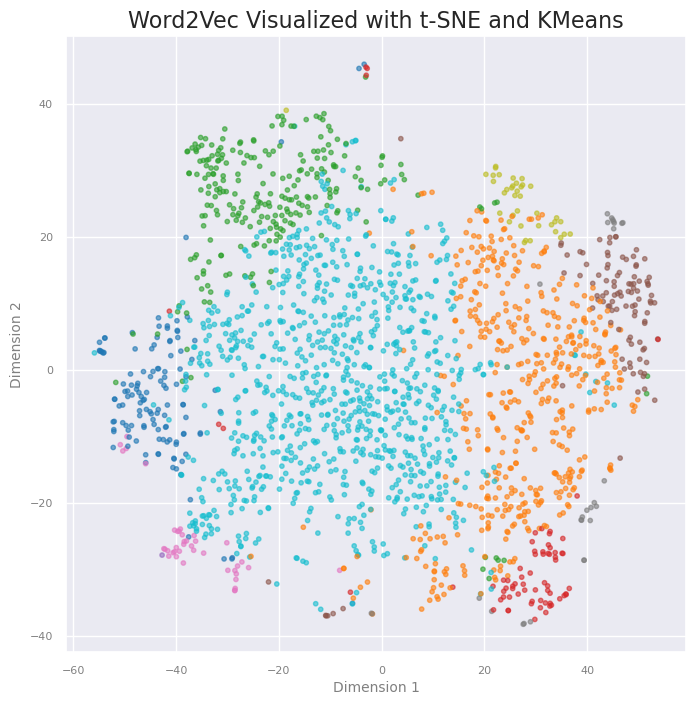

In [6]:
words = list(word2vec_model.wv.index_to_key)  # vocabulary
word_vectors = word2vec_model.wv[words]      # word vectors

# KMeans clustering
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
labels = kmeans.fit_predict(word_vectors)

# Reduce vectors with PCA
#pca = PCA(n_components=2)
#reduced_vectors = pca.fit_transform(word_vectors)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
reduced_vectors = tsne.fit_transform(word_vectors)

#Plot
plt.figure(figsize=(8, 8))
colors = [plt.cm.tab10(label / float(num_clusters)) for label in labels]
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], label=f'Cluster {labels}', c= colors,  s=10, alpha=0.6)

#for i, word in enumerate(words[:500]): # Annotate every 10th word
#    if i % 10 == 0:  
#        plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]), fontsize=8)
plt.title("Word2Vec Visualized with t-SNE and KMeans", fontsize=16)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [7]:
# see words in specific cluster
from collections import defaultdict
clustered_words = defaultdict(list)
for word, label in zip(words, labels):
    clustered_words[label].append(word)
cluster_1_words = clustered_words[1]  
print(f"Words in Cluster 1: {cluster_1_words}")

Words in Cluster 1: ['add', 'set', 'contain', 'map', 'pass', 'path', 'output', 'default', 'current', 'format', 'save', 'address', 'instead', 'convert', 'remove', 'response', 'inside', 'action', 'parse', 'character', 'block', 'loop', 'structure', 'last', 'expect', 'parameters', 'state', 'password', 'specify', 'encode', 'target', 'properties', 'non', 'article', 'wpf', 'next', 'break', 'match', 'replace', 'container', 'controller', 'parameter', 'description', 'utf', 'schema', 'word', 'info', 'child', 'stuff', 'location', 'space', 'simply', 'comment', 'apply', 'yes', 'trigger', 'tree', 'stream', 'none', 'node', 'tab', 'generic', 'enter', 'amount', 'hit', 'section', 'limit', 'namespace', 'fill', 'dictionary', 'sub', 'collection', 'variables', 'assign', 'sequence', 'statement', 'editor', 'course', 'populate', 'cell', 'compare', 'expression', 'determine', 'products', 'draw', 'condition', 'pointer', 'hold', 'clear', 'auto', 'callback', 'focus', 'entry', 'wrap', 'argument', 'handler', 'serializ

## 5. BERT (Bidirectional Encoder Representations from Transformers)
### Sentence embedding

In [8]:
# Charger le tokenizer et le modèle BERT pré-entraîné
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Fonction pour générer les embeddings de phrase avec BERT
def vectorize_with_bert(texts):
     all_embeddings = []
     for text in texts:
         inputs = tokenizer(text, max_length=64, truncation=True, padding=True, return_tensors='pt')
         with torch.no_grad():
             outputs = model(**inputs)
         # Extraire le vecteur de [CLS] token
         cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
         all_embeddings.append(cls_embedding)
     return np.array(all_embeddings)

# Vectorisation des données
X_train_bert = vectorize_with_bert(X_train)
X_test_bert = vectorize_with_bert(X_test)

print("Shape of X_train_bert:", X_train_bert.shape)
print("Shape of X_test_bert:", X_test_bert.shape)

/opt/conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Shape of X_train_bert: (3728, 768)
Shape of X_test_bert: (933, 768)


This plot is a **t-SNE visualization** of BERT embeddings with clusters identified using **KMeans clustering**. 

1. **Dimensionality Reduction:**
   - The BERT embeddings are originally high-dimensional (768 dimensions).
   - **PCA** is used first to reduce the dimensionality to 50 for computational efficiency.
   - Then, **t-SNE** reduces the embeddings further to 2 dimensions, allowing them to be plotted in a 2D space.

2. **Clusters from KMeans:**
   - After generating the embeddings, the KMeans algorithm groups the data into clusters. 

3. **Points in the Plot:**
   - Each point represents a BERT-encoded text sample
   - Groups of points with the same color are part of the same cluster.
   - Some clusters overlap, suggesting similarities between clusters.

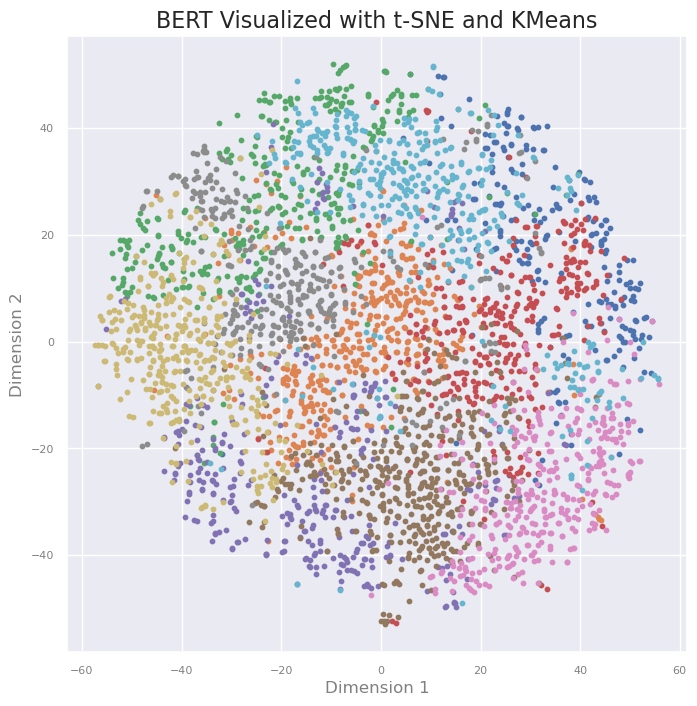

In [9]:
# PCA to reduce dimensionality to 50 
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_bert)

# t-SNE to reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_train_tsne = tsne.fit_transform(X_train_pca)

# KMeans clustering
num_clusters = 10 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(X_train_bert)

# Plot 
plt.figure(figsize=(8, 8))
for cluster in range(num_clusters):
    cluster_points = X_train_tsne[labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=10, label=f'Cluster {cluster}')
plt.title("BERT Visualized with t-SNE and KMeans", fontsize=16)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.show()


## 6. USE (Universal Sentence Encoder)

In [10]:
# Load the Universal Sentence Encoder model
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Function to generate embeddings with USE
def vectorize_with_use(texts):
    # Convert the input to a TensorFlow tensor
    texts_tensor = tf.convert_to_tensor(texts)
    # Use the model to compute embeddings
    embeddings = use_model(texts_tensor)
    return np.array(embeddings)
    
# Vectorize the training and testing data
X_train_use = vectorize_with_use(X_train)
X_test_use = vectorize_with_use(X_test)

print("Shape of X_train_use:", X_train_use.shape)
print("Shape of X_test_use:", X_test_use.shape)

2025-01-22 11:26:54.665278: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34133760 exceeds 10% of free system memory.
2025-01-22 11:26:54.685860: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34133760 exceeds 10% of free system memory.
2025-01-22 11:26:54.716723: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34133760 exceeds 10% of free system memory.
2025-01-22 11:26:54.747662: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34133760 exceeds 10% of free system memory.
2025-01-22 11:26:54.777449: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34133760 exceeds 10% of free system memory.


Shape of X_train_use: (3728, 512)
Shape of X_test_use: (933, 512)


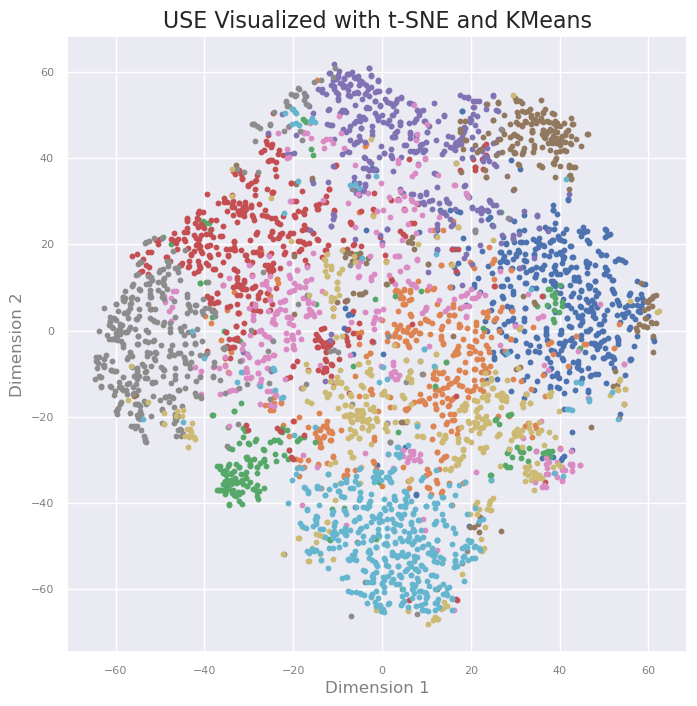

In [11]:
# PCA to reduce dimensionality to 50 
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_use)

# t-SNE to reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_train_tsne = tsne.fit_transform(X_train_pca)

# KMeans clustering
num_clusters = 10 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(X_train_use)

# Plot 
plt.figure(figsize=(8, 8))
for cluster in range(num_clusters):
    cluster_points = X_train_tsne[labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=10, label=f'Cluster {cluster}')
plt.title("USE Visualized with t-SNE and KMeans", fontsize=16)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.show()

## 7. Modeling

In [ ]:
# Define classifiers
classifiers = [
    SGDClassifier(),
    LogisticRegression(solver='saga', max_iter=200),
    LinearSVC(dual=False, C=1.5, penalty='l1', max_iter=1000)
]

def scale_and_train(X_train, X_test, y_train, y_test, classifiers):
    """Scales the data and trains classifiers."""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    for clf in classifiers:
        model = OneVsRestClassifier(clf)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        print(clf, " Jaccard Score:", jaccard_score(y_test, y_pred, average='samples', zero_division=0))

print("BERT---------------------------------")
# Train and evaluate for BERT features
scale_and_train(X_train_bert, X_test_bert, y_train, y_test, classifiers)

print("\n WORD2VEC---------------------------------")
# Train and evaluate for Word2Vec features
scale_and_train(X_train_w2v, X_test_w2v, y_train, y_test, classifiers)

print("\n USE---------------------------------")
# Train and evaluate for USE features
scale_and_train(X_train_use, X_test_use, y_train, y_test, classifiers)

BERT---------------------------------
SGDClassifier()  Jaccard Score: 0.20333962809847053
LogisticRegression(max_iter=200, solver='saga')  Jaccard Score: 0.24889756545705094
LinearSVC(C=1.5, dual=False, penalty='l1')  Jaccard Score: 0.2100720495415029

 WORD2VEC---------------------------------
SGDClassifier()  Jaccard Score: 0.1884038255420892
LogisticRegression(max_iter=200, solver='saga')  Jaccard Score: 0.1411371408155974
LinearSVC(C=1.5, dual=False, penalty='l1')  Jaccard Score: 0.14953554841014646

 USE---------------------------------
SGDClassifier()  Jaccard Score: 0.35380875822998004
LogisticRegression(max_iter=200, solver='saga')  Jaccard Score: 0.38647603736028174
